Training on Kaggle Notebook with P100 GPU Accelerator

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

2025-09-12 02:00:14.452079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757642414.684755      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757642414.747871      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
IMG_SIZE = (224, 224)
BATCH = 32
AUTOTUNE = tf.data.AUTOTUNE

# load dataset dari direktori
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/esai-arsen-v3/dataset-v3/train",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    validation_split=None,
    seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/esai-arsen-v3/dataset-v3/val",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    validation_split=None,
    seed=123
)

# dapatkan nama-nama kategori
class_names = train_ds.class_names
print(f"Classes: {class_names}")

# normalisasi data gambar
def preprocess_data(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

# augmentasi data
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),                 # flip kanan-kiri
    layers.RandomRotation(0.15),                     # rotasi ±15%
    layers.RandomZoom(0.15),                         # zoom in/out
    layers.RandomTranslation(0.1, 0.1),              # geser ±10%
    layers.RandomContrast(0.15),                     # kontras
    layers.GaussianNoise(0.02),                      # noise ringan
], name="data_aug")

def augment_data(image, label):
    image = data_augmentation(image)
    return image, label

# apply normaliasi
train_ds = train_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)

# apply augmentasi hanya pada data train
train_ds = train_ds.map(augment_data, num_parallel_calls=AUTOTUNE)

# optimasi pipeline data
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 9341 files belonging to 4 classes.


I0000 00:00:1757642433.022454      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 2337 files belonging to 4 classes.
Classes: ['a_Baik', 'b_Sedang', 'c_Tidak_Sehat', 'd_Sangat_Tidak_Sehat']


In [ ]:
# fungsi untuk membangun blok (Conv2D + BatchNorm + ReLU)
def conv_bn_relu(x, filters, k=3, s=1, p="same", l2=1e-4, name=""):
    x = layers.Conv2D(filters, k, strides=s, padding=p, use_bias=False,
                      kernel_regularizer=regularizers.l2(l2),
                      name=f"conv_{name}")(x)
    x = layers.BatchNormalization(name=f"bn_{name}")(x)
    x = layers.ReLU(name=f"relu_{name}")(x)
    return x

In [ ]:
def build_AirPolNet(
    input_shape=(224, 224, 3),
    num_channels=32,
    num_classes=4,
    l2=1e-4
) -> Model:
    inputs = layers.Input(shape=input_shape, name="input")

    # blok 1
    x = conv_bn_relu(inputs, num_channels, k=5, p="same", l2=l2, name="b1a")
    x = conv_bn_relu(x,       num_channels, k=3, p="same", l2=l2, name="b1b")
    x = layers.MaxPooling2D(2, name="pooling_1")(x)
    x = layers.SpatialDropout2D(0.1, name="spatial_drop_1")(x)

    # blok 2
    x = conv_bn_relu(x, num_channels*2, k=3, p="same", l2=l2, name="b2a")
    x = conv_bn_relu(x, num_channels*2, k=3, p="same", l2=l2, name="b2b")
    x = layers.MaxPooling2D(2, name="pooling_2")(x)
    x = layers.SpatialDropout2D(0.1, name="spatial_drop_2")(x)

    # blok 3
    x = conv_bn_relu(x, num_channels*4, k=3, p="same", l2=l2, name="b3a")
    x = conv_bn_relu(x, num_channels*4, k=3, p="same", l2=l2, name="b3b")
    x = layers.MaxPooling2D(2, name="pooling_3")(x)

    # head akhir -> global average pooling
    x = layers.GlobalAveragePooling2D(name="gap")(x)
    x = layers.Dropout(0.4, name="drop_gap")(x)
    x = layers.Dense(128, activation="relu",
                     kernel_regularizer=regularizers.l2(l2),
                     name="dense")(x)
    x = layers.Dropout(0.4, name="drop_dense_1")(x)

    # layer output
    outputs = layers.Dense(num_classes, activation="softmax", name="out")(x)
    
    return Model(inputs, outputs, name="AirPolNet")

In [ ]:
# bangun instance model
model = build_AirPolNet()

# compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [5]:
model.summary()

Model: "AirPolNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_b1a (Conv2D)               │ (None, 224, 224, 32)   │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_b1a (BatchNormalization)     │ (None, 224, 224, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_b1a (ReLU)                 │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_b1b (Conv2D)               │ (None, 224, 224, 32)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_b1b (BatchNormalization)     │ (None, 224, 224, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_b1b (ReLU)                 │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_1 (MaxPooling2D)        │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_drop_1                  │ (None, 112, 112, 32)   │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_b2a (Conv2D)               │ (None, 112, 112, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_b2a (BatchNormalization)     │ (None, 112, 112, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_b2a (ReLU)                 │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_b2b (Conv2D)               │ (None, 112, 112, 64)   │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_b2b (BatchNormalization)     │ (None, 112, 112, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_b2b (ReLU)                 │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_2 (MaxPooling2D)        │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_drop_2                  │ (None, 56, 56, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_b3a (Conv2D)               │ (None, 56, 56, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_b3a (BatchNormalization)     │ (None, 56, 56, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_b3a (ReLU)                 │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_b3b (Conv2D)               │ (None, 56, 56, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_b3b (BatchNormalization)     │ (None, 56, 56, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_b3b (ReLU)                 │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_3 (MaxPooling2D)        │ (None, 28, 28, 128)    │             

 Total params: 306,916 (1.17 MB)

 Trainable params: 306,020 (1.17 MB)

 Non-trainable params: 896 (3.50 KB)

In [6]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    ]
)

Epoch 1/100


I0000 00:00:1757642443.415147      99 service.cc:148] XLA service 0x7ec05801cd50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757642443.416126      99 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757642444.381878      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/292 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.1797 - loss: 1.9972   

I0000 00:00:1757642455.102657      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


292/292 ━━━━━━━━━━━━━━━━━━━━ 90s 247ms/step - accuracy: 0.4022 - loss: 1.4287 - val_accuracy: 0.4938 - val_loss: 1.2801 - learning_rate: 1.0000e-04
Epoch 2/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.5573 - loss: 1.0884 - val_accuracy: 0.6898 - val_loss: 0.8649 - learning_rate: 1.0000e-04
Epoch 3/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.6159 - loss: 0.9903 - val_accuracy: 0.7086 - val_loss: 0.7762 - learning_rate: 1.0000e-04
Epoch 4/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.6560 - loss: 0.9161 - val_accuracy: 0.7450 - val_loss: 0.7329 - learning_rate: 1.0000e-04
Epoch 5/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.6824 - loss: 0.8578 - val_accuracy: 0.7604 - val_loss: 0.6795 - learning_rate: 1.0000e-04
Epoch 6/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.6930 - loss: 0.8112 - val_accuracy: 0.7698 - val_loss: 0.6986 - learning_rate: 1.0000e-04
Epoch 7/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - 

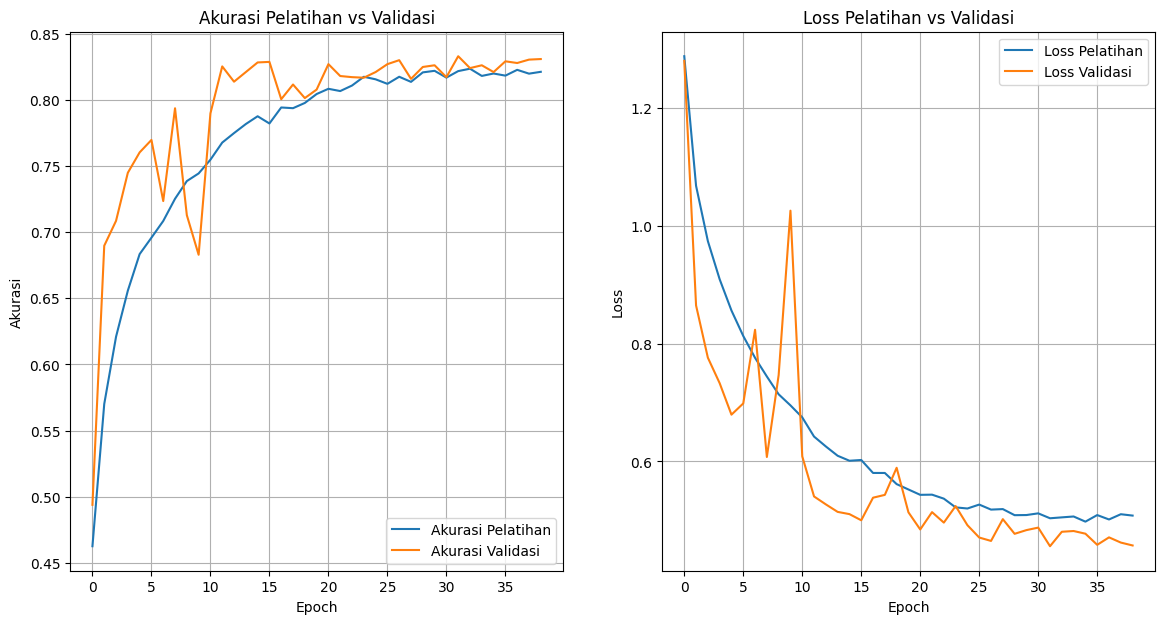

In [ ]:
# get loss dan akurasi
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# plot akurasi
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Akurasi Pelatihan')
plt.plot(epochs_range, val_acc, label='Akurasi Validasi')
plt.legend(loc='lower right')
plt.title('Akurasi Pelatihan vs Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.grid(True)

# plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss Pelatihan')
plt.plot(epochs_range, val_loss, label='Loss Validasi')
plt.legend(loc='upper right')
plt.title('Loss Pelatihan vs Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.savefig('plot_v6.png') 
plt.show()

In [ ]:
# jadikan history menjadi dataframe
history_df = pd.DataFrame(history.history)

# tambah kolom epoch
history_df['epoch'] = history.epoch
print(history_df.head())

# save
history_df.to_csv('history_v6.csv', index=False)

   accuracy      loss  val_accuracy  val_loss  learning_rate  epoch
0  0.462477  1.287966      0.493795  1.280081         0.0001      0
1  0.570067  1.067966      0.689773  0.864889         0.0001      1
2  0.620919  0.974144      0.708601  0.776219         0.0001      2
3  0.655818  0.909340      0.744972  0.732925         0.0001      3
4  0.683439  0.856330      0.760377  0.679491         0.0001      4


In [ ]:
val_ds_noshuffle = val_ds.unbatch().batch(1)

# buat list kosong untuk simpan true dan predicted
y_true = []
y_pred = []

# looping di validasi
for images, labels in val_ds_noshuffle:
    # prediction
    preds = model.predict(images, verbose=0)
    
    # ambil indeks tertinggi
    y_pred.append(np.argmax(preds, axis=1)[0])
    
    # cek label
    if labels.shape[-1] == model.output_shape[-1]:
        # jika one hot jadikan integer
        y_true.append(np.argmax(labels.numpy(), axis=1)[0])
    else:
        # jika sudah integer -> append
        y_true.append(labels.numpy()[0])

# konversi list ke array
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

# nama kelas
classes = [str(c) for c in range(cm.shape[0])]

# heatmap untuk confussion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")


plt.savefig("confusion_matrix_v6.png")
plt.show()

# classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))

In [ ]:
# simpan model dan artefak
model.save('model_v6.keras')
model.save('model_v6.h5')